# AD_with_Plaques:1
# NCI_with_No_Plaques: 0

In [6]:
import os
os.chdir('./../../')

import tensorflow as tf
from gene_expression import *
from pathway_hierarchy import *
from utils import *
import torch

In [74]:
import os
import torch
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import argparse
from utils import *
from gene_expression import *
from pathway_hierarchy import *
import pandas as pd
import yaml
from custom_neural_network import *
from custom_fc_network import *
from datetime import datetime
import csv
import copy
import pickle
import random
random.seed(0)
np.random.seed(0)

path_config = 'config.yml'
model_dct = dict()

# Hook function
def hook_fn(module, input, output, layer_name):
    global model_dct
    input_list = [i.detach().cpu().numpy().tolist() for i in input]
    output_list = output.detach().cpu().numpy().tolist()
    
    # If the layer name is not in the dictionary, create a new list for it
    if layer_name not in model_dct:
        model_dct[layer_name] = []

    # Append the activations to the corresponding layer list
    model_dct[layer_name].append({
        'input': input_list,
        'output': output_list
    })



# Define the file path for the CSV file
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

class TabularDataset(Dataset):
    def __init__(self, count_matrix, label):
        # Read the CSV file
        self.data = count_matrix
        # Separate features and target
        self.features = self.data.values
        self.target = label.values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get features and target for a given index
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        return features, target

def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predicted_list = []
    probability_list = []
    labels_list = []
    criterion = nn.BCEWithLogitsLoss()
    loss = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for features, labels in dataloader:
            outputs = model(features)
            #print(outputs)
            probability = torch.sigmoid(outputs.data)
            predicted = torch.round(torch.sigmoid(outputs.data))
            #print(outputs)
            #print(predicted)
            loss += criterion(outputs, labels)
            #_, predicted = torch.sigmoid(outputs.data)
            predicted_list.extend(predicted)
            labels_list.extend(labels)
            probability_list.extend(probability)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print(total)
    accuracy = 100 * correct / total
    return accuracy, loss, predicted_list, labels_list, probability_list

def save_model(model_nn,model_path, model_state_dict_path):
    
    model_nn.eval()
    torch.save(model_nn, model_path)
    torch.save(model_nn.state_dict(), model_state_dict_path)




def model_fc(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomfcNetwork(layers_node, output_layer, masking)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/fc_training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            outputs = model_nn(batch_features)
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            loss = criterion(outputs, batch_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/fc_test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn



def model(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomNetwork(layers_node, output_layer, masking)
    print(model)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            
            
            optimizer.zero_grad()
            outputs = model_nn(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn


def load_config(config_file):
    with open(config_file, 'r') as file:
        return yaml.safe_load(file)


def main_file(path_config):

    '''parser = argparse.ArgumentParser(description='Sample application with config and argparse')
    parser.add_argument('--config', type=str, default='config.yml', help='Path to the configuration file')
    args = parser.parse_args()'''

    config = load_config(path_config)
    print(config)
    train = pd.read_csv(config['dataset']['train'],index_col=0)
    test = pd.read_csv(config['dataset']['test'],index_col=0)
    val = pd.read_csv(config['dataset']['val'],index_col=0)

    y_train = pd.read_csv(config['dataset']['y_train'])
    y_test = pd.read_csv(config['dataset']['y_test'])
    y_val = pd.read_csv(config['dataset']['y_val'])
  


    r_data_tmp = train.T
    q_data_tmp = test.T
    v_data_tmp = val.T
    r_label_tmp = y_train



    pathway_relation, ensemble_pathway_relation = return_threshold_pathways(config['pathways_network']['pathway_relation'], 
                                  config['pathways_network']['ensemble_pathway_relation'],  config['pathways_network']['h_thresh'],\
                                      config['pathways_network']['l_thresh'])

    if os.path.exists(config['pathways_network']['pathway_relation_updated']):
        os.remove(config['pathways_network']['pathway_relation_updated'])

    if os.path.exists(config['pathways_network']['ensemble_pathway_relation_updated']):
        os.remove(config['pathways_network']['ensemble_pathway_relation_updated'])

    pathway_relation.to_csv(config['pathways_network']['pathway_relation_updated'], sep = '\t', index = False, header= False)
    ensemble_pathway_relation.to_csv(config['pathways_network']['ensemble_pathway_relation_updated'], sep = '\t', index = False, header= False)




    print('Getting Marker Genes.......')
    train_x, test_x, val_x, train_y = get_expression(r_data_tmp,
                                                q_data_tmp,
                                                v_data_tmp,
                                                r_label_tmp,
                                                thrh=config['gene_expression']['highly_expressed_threshold'],
                                                thrl=config['gene_expression']['lowly_expressed_threshold'],
                                                normalization=config['gene_expression']['normalization'],
                                                marker=config['gene_expression']['marker'])
    
    print('Getting Pathway Genes.........')
    pathway_genes = get_gene_pathways(config['pathways_network']['ensemble_pathway_relation_updated'], species=config['pathways_network']['species'])


    print('Getting Masking.........')
    masking, masking_df, layers_node, train_x, test_x,val_x = get_masking(config['pathways_network']['pathway_names'],
                                                        pathway_genes,
                                                        config['pathways_network']['pathway_relation_updated'],
                                                        train_x,
                                                        test_x,
                                                        val_x,
                                                        train_y,
                                                        config['pathways_network']['datatype'],
                                                        config['pathways_network']['species'],
                                                        config['pathways_network']['n_hidden_layer'])

    test_cell_id = list(test_x.T.index) 
    try:
        masking = list(masking.values())
        layers_node = list(layers_node.values())
    except:
        print('already_done')


    train_dataset = TabularDataset(train_x.T,train_y)
    val_dataset = TabularDataset(val_x.T,y_val)
    test_dataset = TabularDataset(test_x.T,y_test)  
    
    

    dataloader_params = {
    'batch_size': config['train']['batch_size'],
    'shuffle': False
    }

    train_dataloader = DataLoader(train_dataset,**dataloader_params)
    test_dataloader = DataLoader(test_dataset, **dataloader_params)
    val_dataloader = DataLoader(val_dataset,**dataloader_params)
    # Example of iterating through the DataLoader


    pred_y_df = pd.DataFrame(data=0, index=test_x.columns, columns=list(range(2, len(masking) + 2)))
    train_y_df = pd.DataFrame(data=0, index=train_x.columns, columns=list(range(2, len(masking) + 2)))
    model_dict_sparse = dict()
    model_dict_fc = dict()
    activation_output = {}
    now = datetime.now()

# Format the date as a string
    date_string = datetime_string = now.strftime("%Y_%m_%d_%H_%M_%S")

    try:
        os.makedirs(f'{config['model_output']['model_save_dir']}{date_string}')
    except:
        print(('...'))

   

    print('Training.........')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_sparse[output_layer] = model(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  

    print('tranining_fully_connected_layers:')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_fc[output_layer] = model_fc(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  
        
    new_parameter = {'date_string': date_string}
    config.update(new_parameter)
    save_path =   str(config['model_output']['model_save_dir'])+ date_string + '/config.yml'
    with open(save_path, 'w') as file:
        yaml.dump(config, file)

        
    for i in range(len(masking_df)):
        masking_df[i].to_csv(str(config['model_output']['model_save_dir'])+ date_string+ '/' +f'masking_df_{i}.csv')
    
   
        
    return model_dict_sparse, val_dataloader, test_dataloader, train_dataloader, train_x, train_y, val_x, y_val, test_x, y_test, config

   
model_dict_sparse, val_dataloader, test_dataloader, train_dataloader,train_x, train_y, val_x, y_val, test_x, y_test, config = main_file(path_config= path_config)
for j,i in model_dict_sparse.items():

# Assuming 'model' is your neural network
    torch.save(i.state_dict(), f'{config['model_output']['model_save_dir']}{config['date_string']}/model_{j}_state_dict_jupyter_notebook.pth')


for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}') 

{'dataset': {'train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv', 'test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv', 'val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv', 'y_train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv', 'y_test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv', 'y_val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'}, 'model_output': {'model_save_dir': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excito

/home/anwer/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



Training.........
Current sub-neural network has 1 hidden layers.
...


  1%|█▋                                                                                                                                                                          | 1/100 [00:00<01:36,  1.03it/s]

Epoch [1/100], Train Loss: 0.6881, Train_accuracy: 50.110046148384804, Val Loss: 0.6874, Val_accuracy: 50.415335463258785
Model saved.


  2%|███▍                                                                                                                                                                        | 2/100 [00:01<01:30,  1.08it/s]

Epoch [2/100], Train Loss: 0.7119, Train_accuracy: 50.315938942137024, Val Loss: 0.7141, Val_accuracy: 49.86155484558041
Epoch [3/100], Train Loss: 0.6720, Train_accuracy: 64.31664891728789, Val Loss: 0.6727, Val_accuracy: 63.85516506922258


  3%|█████▏                                                                                                                                                                      | 3/100 [00:03<01:57,  1.21s/it]

Model saved.


  4%|██████▉                                                                                                                                                                     | 4/100 [00:04<01:44,  1.09s/it]

Epoch [4/100], Train Loss: 0.6882, Train_accuracy: 50.67802626908058, Val Loss: 0.6876, Val_accuracy: 50.94781682641108


  5%|████████▌                                                                                                                                                                   | 5/100 [00:05<01:52,  1.19s/it]

Epoch [5/100], Train Loss: 0.6695, Train_accuracy: 56.04543840965566, Val Loss: 0.6698, Val_accuracy: 56.52822151224707


  6%|██████████▎                                                                                                                                                                 | 6/100 [00:06<01:42,  1.09s/it]

Epoch [6/100], Train Loss: 0.6597, Train_accuracy: 62.790202342918, Val Loss: 0.6616, Val_accuracy: 62.15122470713525


  7%|████████████                                                                                                                                                                | 7/100 [00:07<01:49,  1.18s/it]

Epoch [7/100], Train Loss: 0.6637, Train_accuracy: 57.02520411785588, Val Loss: 0.6668, Val_accuracy: 56.27263045793397


  8%|█████████████▊                                                                                                                                                              | 8/100 [00:08<01:40,  1.09s/it]

Epoch [8/100], Train Loss: 0.6445, Train_accuracy: 64.77103301384452, Val Loss: 0.6474, Val_accuracy: 63.791267305644304
Epoch [9/100], Train Loss: 0.6404, Train_accuracy: 64.92722754703586, Val Loss: 0.6425, Val_accuracy: 64.74973375931842


  9%|███████████████▍                                                                                                                                                            | 9/100 [00:09<01:39,  1.09s/it]

Model saved.


 10%|█████████████████                                                                                                                                                          | 10/100 [00:11<01:45,  1.17s/it]

Epoch [10/100], Train Loss: 0.6370, Train_accuracy: 64.5580404685836, Val Loss: 0.6394, Val_accuracy: 64.21725239616613
Epoch [11/100], Train Loss: 0.6181, Train_accuracy: 68.28541001064963, Val Loss: 0.6224, Val_accuracy: 67.49733759318424


 11%|██████████████████▊                                                                                                                                                        | 11/100 [00:12<01:43,  1.17s/it]

Model saved.


 12%|████████████████████▌                                                                                                                                                      | 12/100 [00:13<01:48,  1.23s/it]

Epoch [12/100], Train Loss: 0.6225, Train_accuracy: 65.3177138800142, Val Loss: 0.6287, Val_accuracy: 63.663471778487754
Epoch [13/100], Train Loss: 0.6035, Train_accuracy: 68.83919062832801, Val Loss: 0.6097, Val_accuracy: 68.00851970181044


 13%|██████████████████████▏                                                                                                                                                    | 13/100 [00:14<01:44,  1.21s/it]

Model saved.


 14%|███████████████████████▉                                                                                                                                                   | 14/100 [00:16<01:48,  1.26s/it]

Epoch [14/100], Train Loss: 0.6041, Train_accuracy: 68.42740504082357, Val Loss: 0.6097, Val_accuracy: 67.71033013844516
Epoch [15/100], Train Loss: 0.5905, Train_accuracy: 70.01774937877174, Val Loss: 0.5973, Val_accuracy: 68.8604898828541


 15%|█████████████████████████▋                                                                                                                                                 | 15/100 [00:17<01:42,  1.21s/it]

Model saved.


 16%|███████████████████████████▎                                                                                                                                               | 16/100 [00:18<01:34,  1.12s/it]

Epoch [16/100], Train Loss: 0.5873, Train_accuracy: 69.66276180333688, Val Loss: 0.5968, Val_accuracy: 68.604898828541


 17%|█████████████████████████████                                                                                                                                              | 17/100 [00:19<01:43,  1.24s/it]

Epoch [17/100], Train Loss: 0.5769, Train_accuracy: 70.94781682641107, Val Loss: 0.5870, Val_accuracy: 69.94675186368477
Model saved.
Epoch [18/100], Train Loss: 0.5736, Train_accuracy: 70.96201632942847, Val Loss: 0.5829, Val_accuracy: 70.01064962726305


 18%|██████████████████████████████▊                                                                                                                                            | 18/100 [00:21<01:39,  1.22s/it]

Model saved.


 19%|████████████████████████████████▍                                                                                                                                          | 19/100 [00:22<01:46,  1.31s/it]

Epoch [19/100], Train Loss: 0.5634, Train_accuracy: 72.04117855875045, Val Loss: 0.5740, Val_accuracy: 70.77742279020234
Model saved.


 20%|██████████████████████████████████▏                                                                                                                                        | 20/100 [00:23<01:39,  1.24s/it]

Epoch [20/100], Train Loss: 0.5620, Train_accuracy: 72.04117855875045, Val Loss: 0.5755, Val_accuracy: 70.94781682641107
Model saved.
Epoch [21/100], Train Loss: 0.5498, Train_accuracy: 73.44692935747248, Val Loss: 0.5634, Val_accuracy: 72.28966986155484


 21%|███████████████████████████████████▉                                                                                                                                       | 21/100 [00:25<01:45,  1.34s/it]

Model saved.


 22%|█████████████████████████████████████▌                                                                                                                                     | 22/100 [00:26<01:34,  1.21s/it]

Epoch [22/100], Train Loss: 0.5514, Train_accuracy: 72.43166489172879, Val Loss: 0.5648, Val_accuracy: 71.395101171459


 23%|███████████████████████████████████████▎                                                                                                                                   | 23/100 [00:27<01:39,  1.29s/it]

Epoch [23/100], Train Loss: 0.5378, Train_accuracy: 74.36989705360313, Val Loss: 0.5535, Val_accuracy: 72.71565495207668
Model saved.
Epoch [24/100], Train Loss: 0.5393, Train_accuracy: 74.04330848420305, Val Loss: 0.5572, Val_accuracy: 72.88604898828541


 24%|█████████████████████████████████████████                                                                                                                                  | 24/100 [00:28<01:34,  1.24s/it]

Model saved.
Epoch [25/100], Train Loss: 0.5292, Train_accuracy: 74.419595314164, Val Loss: 0.5467, Val_accuracy: 73.22683706070288


 25%|██████████████████████████████████████████▊                                                                                                                                | 25/100 [00:29<01:29,  1.19s/it]

Model saved.
Epoch [26/100], Train Loss: 0.5245, Train_accuracy: 74.64678736244231, Val Loss: 0.5432, Val_accuracy: 73.4185303514377


 26%|████████████████████████████████████████████▍                                                                                                                              | 26/100 [00:31<01:36,  1.30s/it]

Model saved.


 27%|██████████████████████████████████████████████▏                                                                                                                            | 27/100 [00:32<01:30,  1.25s/it]

Epoch [27/100], Train Loss: 0.5226, Train_accuracy: 75.4561590344338, Val Loss: 0.5444, Val_accuracy: 73.52502662406816
Model saved.


 28%|███████████████████████████████████████████████▉                                                                                                                           | 28/100 [00:34<01:37,  1.35s/it]

Epoch [28/100], Train Loss: 0.5117, Train_accuracy: 76.06673766418176, Val Loss: 0.5337, Val_accuracy: 74.46219382321618
Model saved.


 29%|█████████████████████████████████████████████████▌                                                                                                                         | 29/100 [00:35<01:27,  1.23s/it]

Epoch [29/100], Train Loss: 0.5114, Train_accuracy: 75.26446574369898, Val Loss: 0.5341, Val_accuracy: 73.37593184238551


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 30/100 [00:36<01:28,  1.26s/it]

Epoch [30/100], Train Loss: 0.5060, Train_accuracy: 76.55662051828186, Val Loss: 0.5319, Val_accuracy: 74.27050053248136
Epoch [31/100], Train Loss: 0.4972, Train_accuracy: 76.76251331203407, Val Loss: 0.5238, Val_accuracy: 75.12247071352503


 31%|█████████████████████████████████████████████████████                                                                                                                      | 31/100 [00:37<01:23,  1.21s/it]

Model saved.


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 32/100 [00:38<01:16,  1.12s/it]

Epoch [32/100], Train Loss: 0.4967, Train_accuracy: 75.91054313099042, Val Loss: 0.5241, Val_accuracy: 73.95101171459
Epoch [33/100], Train Loss: 0.4923, Train_accuracy: 77.58608448704295, Val Loss: 0.5232, Val_accuracy: 75.25026624068158
Model saved.


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 33/100 [00:39<01:24,  1.26s/it]

Epoch [34/100], Train Loss: 0.4837, Train_accuracy: 77.57188498402556, Val Loss: 0.5151, Val_accuracy: 75.31416400425985


 34%|██████████████████████████████████████████████████████████▏                                                                                                                | 34/100 [00:41<01:21,  1.23s/it]

Model saved.


 35%|███████████████████████████████████████████████████████████▊                                                                                                               | 35/100 [00:42<01:22,  1.27s/it]

Epoch [35/100], Train Loss: 0.4809, Train_accuracy: 77.35889243876464, Val Loss: 0.5137, Val_accuracy: 74.90947816826412
Epoch [36/100], Train Loss: 0.4800, Train_accuracy: 78.06176783812566, Val Loss: 0.5165, Val_accuracy: 75.59105431309904


 36%|█████████████████████████████████████████████████████████████▌                                                                                                             | 36/100 [00:43<01:18,  1.22s/it]

Model saved.


 37%|███████████████████████████████████████████████████████████████▎                                                                                                           | 37/100 [00:44<01:19,  1.26s/it]

Epoch [37/100], Train Loss: 0.4745, Train_accuracy: 77.52218672346469, Val Loss: 0.5107, Val_accuracy: 74.65388711395101
Epoch [38/100], Train Loss: 0.4672, Train_accuracy: 78.60134895278665, Val Loss: 0.5067, Val_accuracy: 75.86794462193824


 38%|████████████████████████████████████████████████████████████████▉                                                                                                          | 38/100 [00:46<01:15,  1.22s/it]

Model saved.


 39%|██████████████████████████████████████████████████████████████████▋                                                                                                        | 39/100 [00:46<01:08,  1.13s/it]

Epoch [39/100], Train Loss: 0.4637, Train_accuracy: 78.59424920127796, Val Loss: 0.5053, Val_accuracy: 75.82534611288605


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 40/100 [00:48<01:11,  1.19s/it]

Epoch [40/100], Train Loss: 0.4634, Train_accuracy: 78.13276535321263, Val Loss: 0.5055, Val_accuracy: 74.88817891373802
Epoch [41/100], Train Loss: 0.4629, Train_accuracy: 78.84274050408236, Val Loss: 0.5098, Val_accuracy: 75.91054313099042
Model saved.


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                   | 42/100 [00:50<01:12,  1.25s/it]

Epoch [42/100], Train Loss: 0.4596, Train_accuracy: 78.17536386226482, Val Loss: 0.5054, Val_accuracy: 75.10117145899893
Epoch [43/100], Train Loss: 0.4531, Train_accuracy: 79.09833155839546, Val Loss: 0.5036, Val_accuracy: 76.16613418530352


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                 | 43/100 [00:52<01:09,  1.22s/it]

Model saved.


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                               | 44/100 [00:53<01:10,  1.26s/it]

Epoch [44/100], Train Loss: 0.4472, Train_accuracy: 79.40362087326943, Val Loss: 0.4981, Val_accuracy: 75.86794462193824


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 45/100 [00:54<01:04,  1.17s/it]

Epoch [45/100], Train Loss: 0.4445, Train_accuracy: 79.61661341853035, Val Loss: 0.4974, Val_accuracy: 75.91054313099042
Epoch [46/100], Train Loss: 0.4446, Train_accuracy: 79.56691515796948, Val Loss: 0.5012, Val_accuracy: 76.1874334398296


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                            | 46/100 [00:55<01:09,  1.30s/it]

Model saved.


 47%|████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 47/100 [00:56<01:02,  1.18s/it]

Epoch [47/100], Train Loss: 0.4466, Train_accuracy: 78.7149449769258, Val Loss: 0.5022, Val_accuracy: 75.2076677316294


 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                         | 48/100 [00:57<00:57,  1.12s/it]

Epoch [48/100], Train Loss: 0.4484, Train_accuracy: 79.43911963081293, Val Loss: 0.5104, Val_accuracy: 75.9318423855165


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 49/100 [00:59<01:00,  1.18s/it]

Epoch [49/100], Train Loss: 0.4454, Train_accuracy: 78.67944621938233, Val Loss: 0.5045, Val_accuracy: 75.1863684771033
Epoch [50/100], Train Loss: 0.4358, Train_accuracy: 80.20589279375221, Val Loss: 0.5002, Val_accuracy: 76.48562300319489


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 50/100 [01:00<00:58,  1.17s/it]

Model saved.


 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 51/100 [01:01<01:00,  1.24s/it]

Epoch [51/100], Train Loss: 0.4291, Train_accuracy: 80.36918707845226, Val Loss: 0.4936, Val_accuracy: 76.37912673056444


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 52/100 [01:02<00:55,  1.15s/it]

Epoch [52/100], Train Loss: 0.4303, Train_accuracy: 80.19169329073482, Val Loss: 0.4954, Val_accuracy: 75.97444089456869


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 53/100 [01:03<00:56,  1.21s/it]

Epoch [53/100], Train Loss: 0.4340, Train_accuracy: 80.29108981185658, Val Loss: 0.5043, Val_accuracy: 76.31522896698615


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 54/100 [01:04<00:51,  1.11s/it]

Epoch [54/100], Train Loss: 0.4325, Train_accuracy: 79.72310969116081, Val Loss: 0.5001, Val_accuracy: 75.71884984025559
Epoch [55/100], Train Loss: 0.4246, Train_accuracy: 81.00816471423501, Val Loss: 0.4972, Val_accuracy: 76.76251331203407


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 55/100 [01:05<00:50,  1.12s/it]

Model saved.
Epoch [56/100], Train Loss: 0.4191, Train_accuracy: 81.0365637202698, Val Loss: 0.4917, Val_accuracy: 76.78381256656017


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 56/100 [01:07<00:55,  1.25s/it]

Model saved.


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 57/100 [01:08<00:48,  1.13s/it]

Epoch [57/100], Train Loss: 0.4200, Train_accuracy: 80.80227192048278, Val Loss: 0.4931, Val_accuracy: 76.16613418530352


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 58/100 [01:09<00:50,  1.21s/it]

Epoch [58/100], Train Loss: 0.4229, Train_accuracy: 80.97976570820022, Val Loss: 0.5008, Val_accuracy: 76.71991480298189


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 59/100 [01:10<00:46,  1.13s/it]

Epoch [59/100], Train Loss: 0.4219, Train_accuracy: 80.4898828541001, Val Loss: 0.4972, Val_accuracy: 75.97444089456869


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 60/100 [01:12<00:50,  1.25s/it]

Epoch [60/100], Train Loss: 0.4159, Train_accuracy: 81.55484558040469, Val Loss: 0.4960, Val_accuracy: 76.91160809371672
Model saved.


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 61/100 [01:13<00:45,  1.15s/it]

Epoch [61/100], Train Loss: 0.4106, Train_accuracy: 81.56904508342208, Val Loss: 0.4903, Val_accuracy: 76.59211927582534


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 62/100 [01:14<00:46,  1.22s/it]

Epoch [62/100], Train Loss: 0.4099, Train_accuracy: 81.46254881079162, Val Loss: 0.4906, Val_accuracy: 76.6773162939297
Epoch [63/100], Train Loss: 0.4120, Train_accuracy: 81.57614483493077, Val Loss: 0.4966, Val_accuracy: 77.10330138445154


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 63/100 [01:15<00:44,  1.19s/it]

Model saved.


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 64/100 [01:16<00:40,  1.12s/it]

Epoch [64/100], Train Loss: 0.4134, Train_accuracy: 81.0010649627263, Val Loss: 0.4959, Val_accuracy: 76.1874334398296


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 65/100 [01:17<00:41,  1.18s/it]

Epoch [65/100], Train Loss: 0.4114, Train_accuracy: 81.68974085906993, Val Loss: 0.4992, Val_accuracy: 76.84771033013844


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 66/100 [01:18<00:36,  1.08s/it]

Epoch [66/100], Train Loss: 0.4065, Train_accuracy: 81.40575079872204, Val Loss: 0.4923, Val_accuracy: 76.57082002129926


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 67/100 [01:20<00:38,  1.17s/it]

Epoch [67/100], Train Loss: 0.4020, Train_accuracy: 82.2790202342918, Val Loss: 0.4910, Val_accuracy: 77.03940362087327


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 68/100 [01:21<00:35,  1.10s/it]

Epoch [68/100], Train Loss: 0.4001, Train_accuracy: 82.3074192403266, Val Loss: 0.4902, Val_accuracy: 76.9542066027689


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 69/100 [01:22<00:36,  1.18s/it]

Epoch [69/100], Train Loss: 0.4007, Train_accuracy: 82.0376286829961, Val Loss: 0.4909, Val_accuracy: 76.84771033013844


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 70/100 [01:23<00:33,  1.11s/it]

Epoch [70/100], Train Loss: 0.4026, Train_accuracy: 82.16542421015265, Val Loss: 0.4970, Val_accuracy: 77.08200212992546


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 71/100 [01:24<00:30,  1.05s/it]

Epoch [71/100], Train Loss: 0.4048, Train_accuracy: 81.5406460773873, Val Loss: 0.4968, Val_accuracy: 76.35782747603834


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 72/100 [01:25<00:31,  1.14s/it]

Epoch [72/100], Train Loss: 0.4057, Train_accuracy: 82.04472843450479, Val Loss: 0.5036, Val_accuracy: 76.76251331203407


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 73/100 [01:26<00:28,  1.06s/it]

Epoch [73/100], Train Loss: 0.4036, Train_accuracy: 81.56904508342208, Val Loss: 0.4980, Val_accuracy: 76.29392971246007
Epoch [74/100], Train Loss: 0.3982, Train_accuracy: 82.5275115370962, Val Loss: 0.4977, Val_accuracy: 77.14589989350372


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 74/100 [01:28<00:31,  1.23s/it]

Model saved.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 75/100 [01:29<00:28,  1.14s/it]

Epoch [75/100], Train Loss: 0.3927, Train_accuracy: 82.57720979765708, Val Loss: 0.4908, Val_accuracy: 77.03940362087327


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 76/100 [01:30<00:28,  1.20s/it]

Epoch [76/100], Train Loss: 0.3902, Train_accuracy: 82.96769613063543, Val Loss: 0.4902, Val_accuracy: 77.14589989350372
Epoch [77/100], Train Loss: 0.3909, Train_accuracy: 83.06709265175719, Val Loss: 0.4932, Val_accuracy: 77.25239616613419


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 77/100 [01:31<00:27,  1.18s/it]

Model saved.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 78/100 [01:32<00:24,  1.11s/it]

Epoch [78/100], Train Loss: 0.3935, Train_accuracy: 82.15122470713526, Val Loss: 0.4945, Val_accuracy: 76.61341853035144


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 79/100 [01:33<00:24,  1.17s/it]

Epoch [79/100], Train Loss: 0.3963, Train_accuracy: 82.61270855520057, Val Loss: 0.5025, Val_accuracy: 77.209797657082


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 80/100 [01:34<00:21,  1.08s/it]

Epoch [80/100], Train Loss: 0.3978, Train_accuracy: 81.98083067092652, Val Loss: 0.5006, Val_accuracy: 76.2087326943557


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 81/100 [01:36<00:21,  1.15s/it]

Epoch [81/100], Train Loss: 0.3957, Train_accuracy: 82.57011004614839, Val Loss: 0.5043, Val_accuracy: 77.16719914802982


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 82/100 [01:36<00:19,  1.09s/it]

Epoch [82/100], Train Loss: 0.3902, Train_accuracy: 82.47071352502662, Val Loss: 0.4957, Val_accuracy: 76.4643237486688
Epoch [83/100], Train Loss: 0.3847, Train_accuracy: 83.46467873624424, Val Loss: 0.4937, Val_accuracy: 77.44408945686901


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 83/100 [01:38<00:21,  1.24s/it]

Model saved.
Epoch [84/100], Train Loss: 0.3824, Train_accuracy: 83.60667376641817, Val Loss: 0.4917, Val_accuracy: 77.48668796592119


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 84/100 [01:39<00:19,  1.20s/it]

Model saved.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 85/100 [01:40<00:18,  1.23s/it]

Epoch [85/100], Train Loss: 0.3836, Train_accuracy: 83.08839190628328, Val Loss: 0.4929, Val_accuracy: 77.12460063897764


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 86/100 [01:41<00:16,  1.14s/it]

Epoch [86/100], Train Loss: 0.3864, Train_accuracy: 83.16648917287895, Val Loss: 0.4997, Val_accuracy: 77.31629392971246


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 87/100 [01:42<00:14,  1.08s/it]

Epoch [87/100], Train Loss: 0.3890, Train_accuracy: 82.57011004614839, Val Loss: 0.4995, Val_accuracy: 76.57082002129926


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 88/100 [01:44<00:13,  1.15s/it]

Epoch [88/100], Train Loss: 0.3893, Train_accuracy: 83.07419240326588, Val Loss: 0.5053, Val_accuracy: 76.9542066027689


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 89/100 [01:45<00:12,  1.09s/it]

Epoch [89/100], Train Loss: 0.3864, Train_accuracy: 82.76890308839191, Val Loss: 0.4989, Val_accuracy: 76.6773162939297


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 90/100 [01:46<00:11,  1.18s/it]

Epoch [90/100], Train Loss: 0.3814, Train_accuracy: 83.44337948171814, Val Loss: 0.4983, Val_accuracy: 77.29499467518637


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 91/100 [01:47<00:10,  1.11s/it]

Epoch [91/100], Train Loss: 0.3773, Train_accuracy: 83.75576854810082, Val Loss: 0.4931, Val_accuracy: 77.44408945686901


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 92/100 [01:48<00:09,  1.19s/it]

Epoch [92/100], Train Loss: 0.3760, Train_accuracy: 83.96166134185303, Val Loss: 0.4931, Val_accuracy: 77.40149094781682


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 93/100 [01:49<00:07,  1.12s/it]

Epoch [93/100], Train Loss: 0.3772, Train_accuracy: 83.73446929357472, Val Loss: 0.4965, Val_accuracy: 77.33759318423856


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 94/100 [01:50<00:06,  1.06s/it]

Epoch [94/100], Train Loss: 0.3795, Train_accuracy: 83.23748668796593, Val Loss: 0.4973, Val_accuracy: 76.97550585729499


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 95/100 [01:52<00:05,  1.15s/it]

Epoch [95/100], Train Loss: 0.3820, Train_accuracy: 83.42917997870074, Val Loss: 0.5045, Val_accuracy: 77.06070287539936


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 96/100 [01:53<00:04,  1.09s/it]

Epoch [96/100], Train Loss: 0.3834, Train_accuracy: 82.88249911253106, Val Loss: 0.5024, Val_accuracy: 76.74121405750799


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 97/100 [01:54<00:03,  1.17s/it]

Epoch [97/100], Train Loss: 0.3825, Train_accuracy: 83.41498047568335, Val Loss: 0.5072, Val_accuracy: 76.97550585729499


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 98/100 [01:55<00:02,  1.11s/it]

Epoch [98/100], Train Loss: 0.3790, Train_accuracy: 83.08129215477459, Val Loss: 0.5002, Val_accuracy: 77.01810436634717


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [01:56<00:01,  1.19s/it]

Epoch [99/100], Train Loss: 0.3744, Train_accuracy: 83.96876109336173, Val Loss: 0.4997, Val_accuracy: 77.42279020234292
Epoch [100/100], Train Loss: 0.3710, Train_accuracy: 84.19595314164005, Val Loss: 0.4952, Val_accuracy: 77.61448349307774


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]

Model saved.


Test Accucary 76.98040885860307
tranining_fully_connected_layers:
Current sub-neural network has 1 hidden layers.
...


  1%|█▋                                                                                                                                                                          | 1/100 [00:00<01:27,  1.13it/s]

Epoch [1/100], Train Loss: 9.0853, Train_accuracy: 49.82605608803692, Val Loss: 9.0094, Val_accuracy: 50.24494142705005
Model saved.


  2%|███▍                                                                                                                                                                        | 2/100 [00:01<01:28,  1.10it/s]

Epoch [2/100], Train Loss: 4.0133, Train_accuracy: 49.82605608803692, Val Loss: 3.9799, Val_accuracy: 50.24494142705005


  3%|█████▏                                                                                                                                                                      | 3/100 [00:03<01:47,  1.11s/it]

Epoch [3/100], Train Loss: 1.8598, Train_accuracy: 50.17394391196308, Val Loss: 1.8753, Val_accuracy: 49.75505857294995


  4%|██████▉                                                                                                                                                                     | 4/100 [00:04<01:39,  1.04s/it]

Epoch [4/100], Train Loss: 3.5880, Train_accuracy: 50.17394391196308, Val Loss: 3.6184, Val_accuracy: 49.75505857294995


  5%|████████▌                                                                                                                                                                   | 5/100 [00:05<01:49,  1.15s/it]

Epoch [5/100], Train Loss: 3.0117, Train_accuracy: 50.17394391196308, Val Loss: 3.0370, Val_accuracy: 49.75505857294995


  6%|██████████▎                                                                                                                                                                 | 6/100 [00:06<01:41,  1.08s/it]

Epoch [6/100], Train Loss: 1.1156, Train_accuracy: 50.17394391196308, Val Loss: 1.1239, Val_accuracy: 49.75505857294995


  7%|████████████                                                                                                                                                                | 7/100 [00:07<01:47,  1.16s/it]

Epoch [7/100], Train Loss: 1.8319, Train_accuracy: 49.82605608803692, Val Loss: 1.8169, Val_accuracy: 50.24494142705005


  8%|█████████████▊                                                                                                                                                              | 8/100 [00:08<01:37,  1.06s/it]

Epoch [8/100], Train Loss: 2.8182, Train_accuracy: 49.82605608803692, Val Loss: 2.7947, Val_accuracy: 50.24494142705005


  9%|███████████████▍                                                                                                                                                            | 9/100 [00:09<01:32,  1.01s/it]

Epoch [9/100], Train Loss: 2.4305, Train_accuracy: 49.82605608803692, Val Loss: 2.4102, Val_accuracy: 50.24494142705005


 10%|█████████████████                                                                                                                                                          | 10/100 [00:10<01:41,  1.13s/it]

Epoch [10/100], Train Loss: 1.0996, Train_accuracy: 49.82605608803692, Val Loss: 1.0915, Val_accuracy: 50.24494142705005


 11%|██████████████████▊                                                                                                                                                        | 11/100 [00:11<01:35,  1.07s/it]

Epoch [11/100], Train Loss: 1.2213, Train_accuracy: 50.17394391196308, Val Loss: 1.2307, Val_accuracy: 49.75505857294995


 12%|████████████████████▌                                                                                                                                                      | 12/100 [00:13<01:42,  1.17s/it]

Epoch [12/100], Train Loss: 2.0869, Train_accuracy: 50.17394391196308, Val Loss: 2.1043, Val_accuracy: 49.75505857294995


 13%|██████████████████████▏                                                                                                                                                    | 13/100 [00:14<01:35,  1.10s/it]

Epoch [13/100], Train Loss: 1.9341, Train_accuracy: 50.17394391196308, Val Loss: 1.9502, Val_accuracy: 49.75505857294995


 14%|███████████████████████▉                                                                                                                                                   | 14/100 [00:15<01:41,  1.18s/it]

Epoch [14/100], Train Loss: 1.0150, Train_accuracy: 50.17394391196308, Val Loss: 1.0221, Val_accuracy: 49.75505857294995


 15%|█████████████████████████▋                                                                                                                                                 | 15/100 [00:16<01:32,  1.09s/it]

Epoch [15/100], Train Loss: 0.9597, Train_accuracy: 49.82605608803692, Val Loss: 0.9533, Val_accuracy: 50.24494142705005


 16%|███████████████████████████▎                                                                                                                                               | 16/100 [00:17<01:26,  1.03s/it]

Epoch [16/100], Train Loss: 1.6263, Train_accuracy: 49.82605608803692, Val Loss: 1.6130, Val_accuracy: 50.24494142705005


 17%|█████████████████████████████                                                                                                                                              | 17/100 [00:18<01:34,  1.14s/it]

Epoch [17/100], Train Loss: 1.5030, Train_accuracy: 49.82605608803692, Val Loss: 1.4909, Val_accuracy: 50.24494142705005


 18%|██████████████████████████████▊                                                                                                                                            | 18/100 [00:19<01:25,  1.05s/it]

Epoch [18/100], Train Loss: 0.8193, Train_accuracy: 49.82605608803692, Val Loss: 0.8150, Val_accuracy: 50.24494142705005


 19%|████████████████████████████████▍                                                                                                                                          | 19/100 [00:20<01:31,  1.13s/it]

Epoch [19/100], Train Loss: 0.9573, Train_accuracy: 50.17394391196308, Val Loss: 0.9637, Val_accuracy: 49.75505857294995


 20%|██████████████████████████████████▏                                                                                                                                        | 20/100 [00:21<01:24,  1.06s/it]

Epoch [20/100], Train Loss: 1.3883, Train_accuracy: 50.17394391196308, Val Loss: 1.3994, Val_accuracy: 49.75505857294995


 21%|███████████████████████████████████▉                                                                                                                                       | 21/100 [00:22<01:20,  1.02s/it]

Epoch [21/100], Train Loss: 1.1622, Train_accuracy: 50.17394391196308, Val Loss: 1.1710, Val_accuracy: 49.75505857294995


 22%|█████████████████████████████████████▌                                                                                                                                     | 22/100 [00:23<01:27,  1.12s/it]

Epoch [22/100], Train Loss: 0.6995, Train_accuracy: 50.17394391196308, Val Loss: 0.7005, Val_accuracy: 49.75505857294995


 23%|███████████████████████████████████████▎                                                                                                                                   | 23/100 [00:24<01:21,  1.06s/it]

Epoch [23/100], Train Loss: 1.0099, Train_accuracy: 49.82605608803692, Val Loss: 1.0029, Val_accuracy: 50.24494142705005


 24%|█████████████████████████████████████████                                                                                                                                  | 24/100 [00:26<01:27,  1.16s/it]

Epoch [24/100], Train Loss: 1.1886, Train_accuracy: 49.82605608803692, Val Loss: 1.1796, Val_accuracy: 50.24494142705005


 25%|██████████████████████████████████████████▊                                                                                                                                | 25/100 [00:27<01:21,  1.09s/it]

Epoch [25/100], Train Loss: 0.8573, Train_accuracy: 49.82605608803692, Val Loss: 0.8524, Val_accuracy: 50.24494142705005


 26%|████████████████████████████████████████████▍                                                                                                                              | 26/100 [00:28<01:16,  1.04s/it]

Epoch [26/100], Train Loss: 0.7452, Train_accuracy: 50.17394391196308, Val Loss: 0.7479, Val_accuracy: 49.75505857294995


 27%|██████████████████████████████████████████████▏                                                                                                                            | 27/100 [00:29<01:22,  1.13s/it]

Epoch [27/100], Train Loss: 1.0335, Train_accuracy: 50.17394391196308, Val Loss: 1.0408, Val_accuracy: 49.75505857294995


 28%|███████████████████████████████████████████████▉                                                                                                                           | 28/100 [00:30<01:16,  1.06s/it]

Epoch [28/100], Train Loss: 0.9426, Train_accuracy: 50.17394391196308, Val Loss: 0.9488, Val_accuracy: 49.75505857294995


 29%|█████████████████████████████████████████████████▌                                                                                                                         | 29/100 [00:31<01:21,  1.15s/it]

Epoch [29/100], Train Loss: 0.6945, Train_accuracy: 50.17394391196308, Val Loss: 0.6949, Val_accuracy: 49.75505857294995


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 30/100 [00:32<01:14,  1.07s/it]

Epoch [30/100], Train Loss: 0.8740, Train_accuracy: 49.82605608803692, Val Loss: 0.8688, Val_accuracy: 50.24494142705005


 31%|█████████████████████████████████████████████████████                                                                                                                      | 31/100 [00:33<01:19,  1.16s/it]

Epoch [31/100], Train Loss: 0.9343, Train_accuracy: 49.82605608803692, Val Loss: 0.9282, Val_accuracy: 50.24494142705005


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 32/100 [00:34<01:12,  1.07s/it]

Epoch [32/100], Train Loss: 0.7237, Train_accuracy: 49.82605608803692, Val Loss: 0.7217, Val_accuracy: 50.24494142705005


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 33/100 [00:35<01:07,  1.01s/it]

Epoch [33/100], Train Loss: 0.7738, Train_accuracy: 50.17394391196308, Val Loss: 0.7772, Val_accuracy: 49.75505857294995


 34%|██████████████████████████████████████████████████████████▏                                                                                                                | 34/100 [00:37<01:13,  1.12s/it]

Epoch [34/100], Train Loss: 0.8868, Train_accuracy: 50.17394391196308, Val Loss: 0.8922, Val_accuracy: 49.75505857294995


 35%|███████████████████████████████████████████████████████████▊                                                                                                               | 35/100 [00:37<01:08,  1.05s/it]

Epoch [35/100], Train Loss: 0.7458, Train_accuracy: 50.17394391196308, Val Loss: 0.7486, Val_accuracy: 49.75505857294995


 36%|█████████████████████████████████████████████████████████████▌                                                                                                             | 36/100 [00:39<01:12,  1.14s/it]

Epoch [36/100], Train Loss: 0.7258, Train_accuracy: 49.82605608803692, Val Loss: 0.7237, Val_accuracy: 50.24494142705005


 37%|███████████████████████████████████████████████████████████████▎                                                                                                           | 37/100 [00:40<01:06,  1.06s/it]

Epoch [37/100], Train Loss: 0.8367, Train_accuracy: 49.82605608803692, Val Loss: 0.8322, Val_accuracy: 50.24494142705005


 38%|████████████████████████████████████████████████████████████████▉                                                                                                          | 38/100 [00:41<01:11,  1.15s/it]

Epoch [38/100], Train Loss: 0.7478, Train_accuracy: 49.82605608803692, Val Loss: 0.7450, Val_accuracy: 50.24494142705005


 39%|██████████████████████████████████████████████████████████████████▋                                                                                                        | 39/100 [00:42<01:05,  1.08s/it]

Epoch [39/100], Train Loss: 0.7080, Train_accuracy: 50.17394391196308, Val Loss: 0.7094, Val_accuracy: 49.75505857294995


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 40/100 [00:43<01:01,  1.02s/it]

Epoch [40/100], Train Loss: 0.7980, Train_accuracy: 50.17394391196308, Val Loss: 0.8019, Val_accuracy: 49.75505857294995


 41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 41/100 [00:44<01:05,  1.12s/it]

Epoch [41/100], Train Loss: 0.7391, Train_accuracy: 50.17394391196308, Val Loss: 0.7417, Val_accuracy: 49.75505857294995


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                   | 42/100 [00:45<01:01,  1.06s/it]

Epoch [42/100], Train Loss: 0.7020, Train_accuracy: 49.82605608803692, Val Loss: 0.7009, Val_accuracy: 50.24494142705005


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                 | 43/100 [00:46<01:05,  1.15s/it]

Epoch [43/100], Train Loss: 0.7711, Train_accuracy: 49.82605608803692, Val Loss: 0.7678, Val_accuracy: 50.24494142705005


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                               | 44/100 [00:47<01:00,  1.08s/it]

Epoch [44/100], Train Loss: 0.7261, Train_accuracy: 49.82605608803692, Val Loss: 0.7239, Val_accuracy: 50.24494142705005


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 45/100 [00:49<01:03,  1.16s/it]

Epoch [45/100], Train Loss: 0.7013, Train_accuracy: 50.17394391196308, Val Loss: 0.7024, Val_accuracy: 49.75505857294995


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                            | 46/100 [00:50<00:58,  1.08s/it]

Epoch [46/100], Train Loss: 0.7524, Train_accuracy: 50.17394391196308, Val Loss: 0.7553, Val_accuracy: 49.75505857294995


 47%|████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 47/100 [00:51<00:54,  1.02s/it]

Epoch [47/100], Train Loss: 0.7134, Train_accuracy: 50.17394391196308, Val Loss: 0.7151, Val_accuracy: 49.75505857294995


 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                         | 48/100 [00:52<00:58,  1.12s/it]

Epoch [48/100], Train Loss: 0.7027, Train_accuracy: 49.82605608803692, Val Loss: 0.7016, Val_accuracy: 50.24494142705005


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 49/100 [00:53<00:54,  1.06s/it]

Epoch [49/100], Train Loss: 0.7383, Train_accuracy: 49.82605608803692, Val Loss: 0.7358, Val_accuracy: 50.24494142705005


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 50/100 [00:54<00:57,  1.16s/it]

Epoch [50/100], Train Loss: 0.7028, Train_accuracy: 49.82605608803692, Val Loss: 0.7017, Val_accuracy: 50.24494142705005


 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 51/100 [00:55<00:52,  1.08s/it]

Epoch [51/100], Train Loss: 0.7055, Train_accuracy: 50.17394391196308, Val Loss: 0.7068, Val_accuracy: 49.75505857294995


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 52/100 [00:56<00:56,  1.17s/it]

Epoch [52/100], Train Loss: 0.7261, Train_accuracy: 50.17394391196308, Val Loss: 0.7282, Val_accuracy: 49.75505857294995


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 53/100 [00:57<00:50,  1.08s/it]

Epoch [53/100], Train Loss: 0.6959, Train_accuracy: 50.17394391196308, Val Loss: 0.6966, Val_accuracy: 49.75505857294995


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 54/100 [00:58<00:47,  1.03s/it]

Epoch [54/100], Train Loss: 0.7082, Train_accuracy: 49.82605608803692, Val Loss: 0.7068, Val_accuracy: 50.24494142705005


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 55/100 [01:00<00:50,  1.12s/it]

Epoch [55/100], Train Loss: 0.7147, Train_accuracy: 49.82605608803692, Val Loss: 0.7130, Val_accuracy: 50.24494142705005


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 56/100 [01:01<00:47,  1.07s/it]

Epoch [56/100], Train Loss: 0.6932, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 57/100 [01:02<00:49,  1.16s/it]

Epoch [57/100], Train Loss: 0.7095, Train_accuracy: 50.17394391196308, Val Loss: 0.7111, Val_accuracy: 49.75505857294995


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 58/100 [01:03<00:45,  1.10s/it]

Epoch [58/100], Train Loss: 0.7045, Train_accuracy: 50.17394391196308, Val Loss: 0.7058, Val_accuracy: 49.75505857294995


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 59/100 [01:04<00:47,  1.16s/it]

Epoch [59/100], Train Loss: 0.6943, Train_accuracy: 49.82605608803692, Val Loss: 0.6939, Val_accuracy: 50.24494142705005


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 60/100 [01:05<00:43,  1.08s/it]

Epoch [60/100], Train Loss: 0.7081, Train_accuracy: 49.82605608803692, Val Loss: 0.7067, Val_accuracy: 50.24494142705005


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 61/100 [01:06<00:40,  1.04s/it]

Epoch [61/100], Train Loss: 0.6969, Train_accuracy: 49.82605608803692, Val Loss: 0.6962, Val_accuracy: 50.24494142705005


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 62/100 [01:07<00:43,  1.13s/it]

Epoch [62/100], Train Loss: 0.6975, Train_accuracy: 50.17394391196308, Val Loss: 0.6983, Val_accuracy: 49.75505857294995


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 63/100 [01:08<00:38,  1.05s/it]

Epoch [63/100], Train Loss: 0.7039, Train_accuracy: 50.17394391196308, Val Loss: 0.7051, Val_accuracy: 49.75505857294995


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 64/100 [01:10<00:41,  1.15s/it]

Epoch [64/100], Train Loss: 0.6934, Train_accuracy: 50.17394391196308, Val Loss: 0.6936, Val_accuracy: 49.75505857294995


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 65/100 [01:10<00:37,  1.08s/it]

Epoch [65/100], Train Loss: 0.7001, Train_accuracy: 49.82605608803692, Val Loss: 0.6991, Val_accuracy: 50.24494142705005


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 66/100 [01:12<00:39,  1.16s/it]

Epoch [66/100], Train Loss: 0.6984, Train_accuracy: 49.82605608803692, Val Loss: 0.6975, Val_accuracy: 50.24494142705005


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 67/100 [01:13<00:35,  1.08s/it]

Epoch [67/100], Train Loss: 0.6938, Train_accuracy: 50.17394391196308, Val Loss: 0.6941, Val_accuracy: 49.75505857294995


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 68/100 [01:14<00:32,  1.01s/it]

Epoch [68/100], Train Loss: 0.7000, Train_accuracy: 50.17394391196308, Val Loss: 0.7010, Val_accuracy: 49.75505857294995


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 69/100 [01:15<00:34,  1.12s/it]

Epoch [69/100], Train Loss: 0.6942, Train_accuracy: 50.17394391196308, Val Loss: 0.6946, Val_accuracy: 49.75505857294995


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 70/100 [01:16<00:31,  1.05s/it]

Epoch [70/100], Train Loss: 0.6960, Train_accuracy: 49.82605608803692, Val Loss: 0.6954, Val_accuracy: 50.24494142705005


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 71/100 [01:17<00:32,  1.12s/it]

Epoch [71/100], Train Loss: 0.6973, Train_accuracy: 49.82605608803692, Val Loss: 0.6966, Val_accuracy: 50.24494142705005


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 72/100 [01:18<00:29,  1.05s/it]

Epoch [72/100], Train Loss: 0.6932, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 73/100 [01:19<00:30,  1.15s/it]

Epoch [73/100], Train Loss: 0.6971, Train_accuracy: 50.17394391196308, Val Loss: 0.6979, Val_accuracy: 49.75505857294995


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 74/100 [01:20<00:28,  1.08s/it]

Epoch [74/100], Train Loss: 0.6943, Train_accuracy: 50.17394391196308, Val Loss: 0.6947, Val_accuracy: 49.75505857294995


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 75/100 [01:21<00:25,  1.02s/it]

Epoch [75/100], Train Loss: 0.6945, Train_accuracy: 49.82605608803692, Val Loss: 0.6941, Val_accuracy: 50.24494142705005


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 76/100 [01:22<00:26,  1.11s/it]

Epoch [76/100], Train Loss: 0.6959, Train_accuracy: 49.82605608803692, Val Loss: 0.6953, Val_accuracy: 50.24494142705005


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 77/100 [01:23<00:24,  1.06s/it]

Epoch [77/100], Train Loss: 0.6931, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 78/100 [01:25<00:25,  1.15s/it]

Epoch [78/100], Train Loss: 0.6955, Train_accuracy: 50.17394391196308, Val Loss: 0.6961, Val_accuracy: 49.75505857294995


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 79/100 [01:26<00:22,  1.07s/it]

Epoch [79/100], Train Loss: 0.6939, Train_accuracy: 50.17394391196308, Val Loss: 0.6942, Val_accuracy: 49.75505857294995


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 80/100 [01:27<00:23,  1.16s/it]

Epoch [80/100], Train Loss: 0.6940, Train_accuracy: 49.82605608803692, Val Loss: 0.6936, Val_accuracy: 50.24494142705005


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 81/100 [01:28<00:20,  1.07s/it]

Epoch [81/100], Train Loss: 0.6948, Train_accuracy: 49.82605608803692, Val Loss: 0.6943, Val_accuracy: 50.24494142705005


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 82/100 [01:29<00:18,  1.01s/it]

Epoch [82/100], Train Loss: 0.6932, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 83/100 [01:30<00:18,  1.10s/it]

Epoch [83/100], Train Loss: 0.6946, Train_accuracy: 50.17394391196308, Val Loss: 0.6951, Val_accuracy: 49.75505857294995


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 84/100 [01:31<00:16,  1.02s/it]

Epoch [84/100], Train Loss: 0.6935, Train_accuracy: 50.17394391196308, Val Loss: 0.6937, Val_accuracy: 49.75505857294995


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 85/100 [01:32<00:16,  1.13s/it]

Epoch [85/100], Train Loss: 0.6938, Train_accuracy: 49.82605608803692, Val Loss: 0.6935, Val_accuracy: 50.24494142705005


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 86/100 [01:33<00:14,  1.07s/it]

Epoch [86/100], Train Loss: 0.6940, Train_accuracy: 49.82605608803692, Val Loss: 0.6937, Val_accuracy: 50.24494142705005


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 87/100 [01:35<00:14,  1.14s/it]

Epoch [87/100], Train Loss: 0.6932, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 88/100 [01:35<00:12,  1.06s/it]

Epoch [88/100], Train Loss: 0.6941, Train_accuracy: 50.17394391196308, Val Loss: 0.6945, Val_accuracy: 49.75505857294995


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 89/100 [01:36<00:11,  1.02s/it]

Epoch [89/100], Train Loss: 0.6932, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 90/100 [01:38<00:11,  1.11s/it]

Epoch [90/100], Train Loss: 0.6937, Train_accuracy: 49.82605608803692, Val Loss: 0.6935, Val_accuracy: 50.24494142705005


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 91/100 [01:39<00:09,  1.06s/it]

Epoch [91/100], Train Loss: 0.6935, Train_accuracy: 49.82605608803692, Val Loss: 0.6933, Val_accuracy: 50.24494142705005


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 92/100 [01:40<00:09,  1.14s/it]

Epoch [92/100], Train Loss: 0.6933, Train_accuracy: 50.17394391196308, Val Loss: 0.6935, Val_accuracy: 49.75505857294995


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 93/100 [01:41<00:07,  1.07s/it]

Epoch [93/100], Train Loss: 0.6937, Train_accuracy: 50.17394391196308, Val Loss: 0.6940, Val_accuracy: 49.75505857294995


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 94/100 [01:42<00:06,  1.14s/it]

Epoch [94/100], Train Loss: 0.6931, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 95/100 [01:43<00:05,  1.06s/it]

Epoch [95/100], Train Loss: 0.6936, Train_accuracy: 49.82605608803692, Val Loss: 0.6934, Val_accuracy: 50.24494142705005


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 96/100 [01:44<00:04,  1.02s/it]

Epoch [96/100], Train Loss: 0.6932, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 97/100 [01:45<00:03,  1.13s/it]

Epoch [97/100], Train Loss: 0.6934, Train_accuracy: 50.17394391196308, Val Loss: 0.6936, Val_accuracy: 49.75505857294995


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 98/100 [01:46<00:02,  1.05s/it]

Epoch [98/100], Train Loss: 0.6933, Train_accuracy: 50.17394391196308, Val Loss: 0.6935, Val_accuracy: 49.75505857294995


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [01:48<00:01,  1.15s/it]

Epoch [99/100], Train Loss: 0.6932, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.09s/it]

Epoch [100/100], Train Loss: 0.6934, Train_accuracy: 49.82605608803692, Val Loss: 0.6932, Val_accuracy: 50.24494142705005


Test Accucary 50.27683134582624
Hidden_Layers: 2
Test Accuracy: 76.98040885860307
Train Accuracy: 84.19595314164005
Validation Accuracy: 77.61448349307774


In [75]:

train_dataset = TabularDataset(train_x.T,train_y)
val_dataset = TabularDataset(val_x.T,y_val)
test_dataset = TabularDataset(test_x.T,y_test) 

dataloader_params = {
    'batch_size': 1,
    'shuffle': False
    }

train_dataloader = DataLoader(train_dataset,**dataloader_params)
test_dataloader = DataLoader(test_dataset, **dataloader_params)
val_dataloader = DataLoader(val_dataset,**dataloader_params)

for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}')

Hidden_Layers: 2
Test Accuracy: 76.98040885860307
Train Accuracy: 84.19595314164005
Validation Accuracy: 77.61448349307774


In [76]:
config

{'dataset': {'train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv',
  'test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv',
  'val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv',
  'y_train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv',
  'y_test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv',
  'y_val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'},
 'model_output': {'model_save_dir': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/model_

In [14]:
config['model_output']['model_save_dir'] 

'/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/'

In [77]:
train_x

cell_id,GTACAACAGGCGTTGA.21.11,GAGTTGTAGCAACAGC.42.2,ACACCAATCCCGATCT.23.6,GCACATAAGAATCTAG.10.7,AAGACCTAGCCTATGT.13.1,ACTTACTGTCAGAAGC.8.1,CACAGGCAGAATCTCC.38.1,CGAGCCAGTATTACCG.29.0,ACCCAAAGTGACCTGC.1.5,CGGACGTTCATGTGGT.15.1,...,AGGGCCTTCGAGAACG.12.14,GCGATCGCACCTCTAC.12.11,ATGTCTTGTTCACCGG.16.2,TGCAGTACAACCAATC.26.2,CGGACGTCACGGTAGA.19.0,CTAACCCTCCCGGTAG.31.6,TCGGGCATCCCAGTGG.12.14,ATCACGAGTATCACCA.6.2,AAGACTCGTTGGGTAG.10.7,GATGATCCAGCCATTA.30.6
ENSG00000196782,0.000000,0.000000,0.835170,0.000000,0.0000,2.391544,0.0,0.000000,1.630036,2.318932,...,2.345670,1.060421,0.000000,0.360711,0.000000,0.000000,1.351873,0.501618,1.448218,0.454942
ENSG00000196542,0.000000,0.000000,0.000000,0.682226,0.0000,0.000000,0.0,0.000000,0.504917,0.000000,...,0.000000,0.625523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000023608,0.000000,1.145814,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.861235,0.000000,0.000000,0.000000,1.012347,0.000000,0.000000,0.000000,0.656484,0.000000
ENSG00000107341,2.006299,0.000000,1.745110,0.381069,0.0000,1.643206,0.0,0.000000,1.174485,0.000000,...,1.396810,0.000000,0.940507,1.710379,1.012347,2.796772,2.037335,0.501618,1.105994,1.689015
ENSG00000177169,2.006299,0.000000,0.835170,1.328568,0.0000,0.000000,0.0,0.000000,0.878202,0.000000,...,0.000000,0.000000,1.505080,0.649033,0.000000,0.000000,0.000000,0.873105,0.000000,1.078734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000170348,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,2.382166,0.504917,1.582466,...,0.000000,0.000000,1.505080,0.649033,0.000000,0.000000,0.000000,0.000000,1.105994,0.454942
ENSG00000196639,0.000000,0.000000,2.048331,0.000000,0.0000,0.000000,0.0,0.000000,0.504917,0.000000,...,0.000000,0.625523,0.000000,0.000000,0.000000,0.000000,0.828808,0.000000,0.000000,0.454942
ENSG00000107897,2.006299,1.145814,0.000000,0.000000,3.4106,1.643206,0.0,0.000000,0.878202,0.000000,...,0.000000,0.000000,0.000000,0.360711,0.000000,1.990744,0.000000,0.000000,0.000000,0.000000
ENSG00000002330,0.000000,0.000000,0.000000,0.381069,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,...,1.396810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [78]:
model_dict_sparse

{2: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=2309, out_features=1356, bias=False)
     (1): Linear(in_features=1356, out_features=1, bias=True)
   )
 )}

In [79]:
model_dict_sparse[2]

CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2309, out_features=1356, bias=False)
    (1): Linear(in_features=1356, out_features=1, bias=True)
  )
)

In [81]:
'''accuracy, loss, predicted_list, labels_list, probability_list = evaluate(model_dict_sparse[2], test_dataloader)
accuracy'''

'accuracy, loss, predicted_list, labels_list, probability_list = evaluate(model_dict_sparse[2], test_dataloader)\naccuracy'

In [82]:
for features, labels in test_dataloader:
    print(labels)
    print(features.shape)
    break

tensor([[1.]])
torch.Size([1, 2309])


In [83]:
model_dict_sparse

{2: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=2309, out_features=1356, bias=False)
     (1): Linear(in_features=1356, out_features=1, bias=True)
   )
 )}

# Result Analysis

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def confusion_matrix_return(result):
    cm = confusion_matrix(result['true_y'], result['pred_y'])
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

def roc_curve_return(result):
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(result['true_y'], result['probabilty'])
    
    # Calculate the AUC
    auc = roc_auc_score(result['true_y'], result['probabilty'])
    print(f'AUC: {auc}')
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [23]:


import pandas as pd
from sklearn.metrics import precision_score

# Sample DataFrame
def return_accuracy(result):
    df = result.copy()
    
    # Calculate positive accuracy (precision for positive class)
    positive_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=1)
    
    # Calculate negative accuracy (precision for negative class)
    negative_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=0)
    
    print(f'Positive Accuracy (Precision for positive class): {positive_accuracy}')
    print(f'Negative Accuracy (Precision for negative class): {negative_accuracy}')

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 1


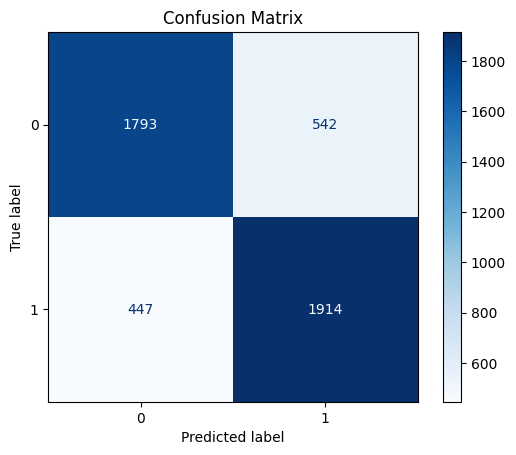

AUC: 0.8655449411248275


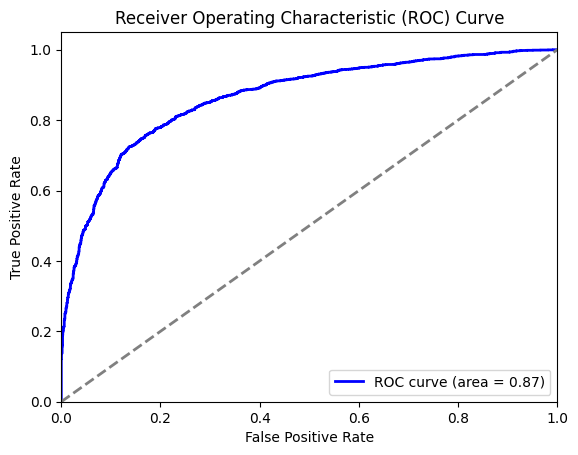

Positive Accuracy (Precision for positive class): 0.7793159609120521
Negative Accuracy (Precision for negative class): 0.8004464285714286


In [24]:
dir_path = config['model_output']['model_save_dir'] + config['date_string']+ '/' + 'test_log_'

for i in range(2,config['pathways_network']['n_hidden_layer']+2):
    print('-'*282)
    print(f'Number of Hidden Layers: {i-1}')
    result = pd.read_csv(f'{dir_path}{i}.csv',index_col=0)

    confusion_matrix_return(result)
    roc_curve_return(result)
    return_accuracy(result)

# Model Interpretation

In [25]:
# Define a hook function to capture the activations


def get_activation(name, number_of_layers, config, activations):
    def hook(model, input, output):
        # Convert output to numpy array for easier handling, but this is optional
        activations[name] = output.detach().numpy()
        
           
    return hook
def attaching_hook(model, dataloader):
    
        correct = 0
        total = 0
        predicted_list = []
        probability_list = []
        labels_list = []
        activations_list = []
        features_list = []
        criterion = nn.BCEWithLogitsLoss()
        loss = 0
        

        with torch.no_grad():  # No need to compute gradients during evaluation
            for sample_idx, (features, labels) in tqdm(enumerate(dataloader)):
                
                
                #print(labels)
                #print(features.shape)
                activations = {}
                for idx, layer in enumerate(model.layers):
                    layer_name = f'layer_{idx}'
                    number_of_layers = len(model.layers)
                    activation_hook = get_activation(layer_name, number_of_layers, config, activations)
                    
                    layer.register_forward_hook(activation_hook)
    
                outputs =  model(features)
                    #print(outputs)
                probability = torch.sigmoid(outputs.data)
                predicted = torch.round(torch.sigmoid(outputs.data))
                    #print(outputs)
                    #print(predicted)
                #loss += criterion(outputs, labels)
                    #_, predicted = torch.sigmoid(outputs.data)
                predicted_list.extend(predicted.detach().numpy())
                labels_list.extend(labels.detach().numpy())
                probability_list.extend(probability.detach().numpy())
                features_list.append(features)
                total += labels.size(0)
                x = activations
                activations_temp = activations.copy()
                activations_list.append(activations_temp)
                
                correct += (predicted == labels).sum().item()
                '''if sample_idx == 1000:
                    #print(activations_list)
                    break'''
                
            #print(total)
        accuracy = 100 * correct / total
        #print(activations_list)
        return activations_list, accuracy, predicted_list, labels_list, features_list,x
        


In [26]:

def return_feature_importance(model_dict_sparse, dataloader):
    predicted_list_dict = {}
    ground_truth_list_dict = {}
    activations_list_dict = {}
    accuracy_list_dict = {}
    for i, j in model_dict_sparse.items():
        #accuracy, loss, predicted_list, labels_list, probability_list = evaluate(j, dataloader)
        
        activations_list_dict[f'model_{i}_hidden_layers'], accuracy_list_dict[f'model_{i}_hidden_layers'], \
        predicted_list_dict[f'model_{i}_hidden_layers'], ground_truth_list_dict[f'model_{i}_hidden_layers'], \
        feature_list,x= attaching_hook(j, dataloader)
        print(f'{i} Layers: {accuracy_list_dict[f'model_{i}_hidden_layers']}')
        
    return activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x

In [27]:

activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x = return_feature_importance(model_dict_sparse, test_dataloader)

4696it [00:51, 91.29it/s] 

2 Layers: 78.93952299829643


In [28]:
def return_feature_importance_list(activations_list_dict, model_name):
    m=0
    for k in tqdm(activations_list_dict[model_name]):
        #print(k)
        if m == 0:
            layer_dict = {key: [] for key in list(k.keys())}
        m = m+1
        
        #print(k['0_layer_0'])
        for z in list(layer_dict.keys()):
            #print(k)
            layer_dict[z].append(k[z][0])

    return layer_dict
    

In [29]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_2_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))
    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])
layer_0_df

li = []
for i in layer_dict['layer_1']:
    li.append(list(i))
    
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 978900.23it/s]


In [30]:
layer_0_df

,R-HSA-163765,R-HSA-209543,R-HSA-350864,R-HSA-8985801,R-HSA-420597,R-HSA-5682910,R-HSA-1855191,R-HSA-3065679,R-HSA-2871809,R-HSA-9037628,...,R-HSA-354194,R-HSA-8981607,R-HSA-196836,R-HSA-9634638,R-HSA-2894862,R-HSA-9639288,R-HSA-211979,R-HSA-180292,R-HSA-173107,R-HSA-5221030
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,0.098598,-0.267047,0.122530,0.199801,-0.021064,0.247003,-0.068726,0.015783,0.249392,0.076322,...,-0.056117,-0.263296,0.071379,-0.072138,0.204242,0.068173,0.089477,-0.101001,-0.119746,0.157962
AGCTTCCGTCTCTCTG.9.9,0.325595,0.216755,-0.064598,-0.097056,-0.134843,-0.016971,0.023574,0.238850,-0.012932,-0.055302,...,0.020521,-0.351654,0.245871,-0.063117,-0.055054,0.151093,0.058960,0.119697,0.266017,-0.397090
CGCCAGACAACAAGTA.17.11,-0.056607,-0.397140,-0.031511,0.129000,-0.032539,0.016086,-0.220884,0.012346,-0.025727,-0.081457,...,-0.169593,-0.331856,0.051412,-0.284395,0.093609,-0.004401,0.129238,0.054966,0.120645,-0.026976
GGGATGATCGTAACAC.7.4,-0.057646,-0.456963,0.080570,0.065666,-0.080691,0.151168,-0.207968,0.126555,0.169998,-0.214422,...,-0.010012,-0.326620,-0.109779,-0.389189,0.038783,-0.220545,0.366010,0.019010,0.279525,0.007284
ACGTTCCGTATTCTCT.5.11,-0.272852,0.062532,0.136487,0.759582,0.063265,0.239064,0.029495,-0.081854,0.203495,0.117849,...,-0.063262,-0.045582,0.131580,-0.556973,-0.182690,0.124835,0.123019,-0.267963,0.427100,-0.558462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,0.009477,-0.032095,-0.284731,0.154393,0.018448,0.164852,0.282768,-0.044348,0.117866,0.326558,...,-0.528381,-0.170965,-0.002497,-0.172656,-0.335121,-0.185627,0.063145,-0.025418,0.033505,-0.138089
GTCAGCGGTCTGATAC.45.2,-0.453529,-0.551991,0.286779,-0.161632,-0.019789,0.233086,-0.200262,-0.109488,-0.068856,-0.098831,...,-0.259162,-0.153657,-0.215616,-0.199737,0.115738,-0.127202,0.141227,0.121770,0.329321,-0.072125
CATGCTCAGTGTCATC.30.10,-0.186330,-0.493703,0.058610,0.026768,0.000695,0.035160,-0.307609,0.112889,-0.088349,-0.025134,...,0.372555,-0.301803,-0.115851,-0.263401,0.084865,0.137970,0.176228,0.048663,0.037567,0.169942


In [34]:
layer_0_df

,R-HSA-163765,R-HSA-209543,R-HSA-350864,R-HSA-8985801,R-HSA-420597,R-HSA-5682910,R-HSA-1855191,R-HSA-3065679,R-HSA-2871809,R-HSA-9037628,...,R-HSA-354194,R-HSA-8981607,R-HSA-196836,R-HSA-9634638,R-HSA-2894862,R-HSA-9639288,R-HSA-211979,R-HSA-180292,R-HSA-173107,R-HSA-5221030
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,0.098598,-0.267047,0.122530,0.199801,-0.021064,0.247003,-0.068726,0.015783,0.249392,0.076322,...,-0.056117,-0.263296,0.071379,-0.072138,0.204242,0.068173,0.089477,-0.101001,-0.119746,0.157962
AGCTTCCGTCTCTCTG.9.9,0.325595,0.216755,-0.064598,-0.097056,-0.134843,-0.016971,0.023574,0.238850,-0.012932,-0.055302,...,0.020521,-0.351654,0.245871,-0.063117,-0.055054,0.151093,0.058960,0.119697,0.266017,-0.397090
CGCCAGACAACAAGTA.17.11,-0.056607,-0.397140,-0.031511,0.129000,-0.032539,0.016086,-0.220884,0.012346,-0.025727,-0.081457,...,-0.169593,-0.331856,0.051412,-0.284395,0.093609,-0.004401,0.129238,0.054966,0.120645,-0.026976
GGGATGATCGTAACAC.7.4,-0.057646,-0.456963,0.080570,0.065666,-0.080691,0.151168,-0.207968,0.126555,0.169998,-0.214422,...,-0.010012,-0.326620,-0.109779,-0.389189,0.038783,-0.220545,0.366010,0.019010,0.279525,0.007284
ACGTTCCGTATTCTCT.5.11,-0.272852,0.062532,0.136487,0.759582,0.063265,0.239064,0.029495,-0.081854,0.203495,0.117849,...,-0.063262,-0.045582,0.131580,-0.556973,-0.182690,0.124835,0.123019,-0.267963,0.427100,-0.558462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,0.009477,-0.032095,-0.284731,0.154393,0.018448,0.164852,0.282768,-0.044348,0.117866,0.326558,...,-0.528381,-0.170965,-0.002497,-0.172656,-0.335121,-0.185627,0.063145,-0.025418,0.033505,-0.138089
GTCAGCGGTCTGATAC.45.2,-0.453529,-0.551991,0.286779,-0.161632,-0.019789,0.233086,-0.200262,-0.109488,-0.068856,-0.098831,...,-0.259162,-0.153657,-0.215616,-0.199737,0.115738,-0.127202,0.141227,0.121770,0.329321,-0.072125
CATGCTCAGTGTCATC.30.10,-0.186330,-0.493703,0.058610,0.026768,0.000695,0.035160,-0.307609,0.112889,-0.088349,-0.025134,...,0.372555,-0.301803,-0.115851,-0.263401,0.084865,0.137970,0.176228,0.048663,0.037567,0.169942


In [35]:
last_layer_df

,last_layer
cell_id,
CACAACATCGTCCTTG.26.2,1.815810
AGCTTCCGTCTCTCTG.9.9,-3.057525
CGCCAGACAACAAGTA.17.11,-1.273272
GGGATGATCGTAACAC.7.4,5.325348
ACGTTCCGTATTCTCT.5.11,-2.757563
...,...
CATCAAGTCCTCGCAT.19.1,-1.907076
GTCAGCGGTCTGATAC.45.2,2.357688
CATGCTCAGTGTCATC.30.10,2.798675


In [36]:
y_test

,diagnosis
0,1
1,0
2,0
3,1
4,1
...,...
4691,1
4692,1
4693,1
4694,0


In [37]:
for i,j in predicted_list_dict.items():
    flattened_list = [item for sublist in list(predicted_list_dict[i]) for item in sublist]
    predicted_list_dict[i] = flattened_list
    

In [38]:
predicted_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [39]:
predicted_list_dict['model_4_hidden_layers'][0:10]

KeyError: 'model_4_hidden_layers'

In [40]:
for i,j in ground_truth_list_dict.items():
    flattened_list = [item for sublist in list(ground_truth_list_dict[i]) for item in sublist]
    ground_truth_list_dict[i] = flattened_list
    

In [41]:
ground_truth_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [42]:
ground_truth_list_dict['model_4_hidden_layers'][0:10]

KeyError: 'model_4_hidden_layers'

In [43]:
predicted_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [44]:
layer_0_df['predicted'] = predicted_list_dict['model_2_hidden_layers']
layer_0_df['ground_truth'] = ground_truth_list_dict['model_2_hidden_layers']
layer_0_df.head()

,R-HSA-163765,R-HSA-209543,R-HSA-350864,R-HSA-8985801,R-HSA-420597,R-HSA-5682910,R-HSA-1855191,R-HSA-3065679,R-HSA-2871809,R-HSA-9037628,...,R-HSA-196836,R-HSA-9634638,R-HSA-2894862,R-HSA-9639288,R-HSA-211979,R-HSA-180292,R-HSA-173107,R-HSA-5221030,predicted,ground_truth
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,0.098598,-0.267047,0.122530,0.199801,-0.021064,0.247003,-0.068726,0.015783,0.249392,0.076322,...,0.071379,-0.072138,0.204242,0.068173,0.089477,-0.101001,-0.119746,0.157962,1.0,1.0
AGCTTCCGTCTCTCTG.9.9,0.325595,0.216755,-0.064598,-0.097056,-0.134843,-0.016971,0.023574,0.238850,-0.012932,-0.055302,...,0.245871,-0.063117,-0.055054,0.151093,0.058960,0.119697,0.266017,-0.397090,0.0,0.0
CGCCAGACAACAAGTA.17.11,-0.056607,-0.397140,-0.031511,0.129000,-0.032539,0.016086,-0.220884,0.012346,-0.025727,-0.081457,...,0.051412,-0.284395,0.093609,-0.004401,0.129238,0.054966,0.120645,-0.026976,0.0,0.0
GGGATGATCGTAACAC.7.4,-0.057646,-0.456963,0.080570,0.065666,-0.080691,0.151168,-0.207968,0.126555,0.169998,-0.214422,...,-0.109779,-0.389189,0.038783,-0.220545,0.366010,0.019010,0.279525,0.007284,1.0,1.0
ACGTTCCGTATTCTCT.5.11,-0.272852,0.062532,0.136487,0.759582,0.063265,0.239064,0.029495,-0.081854,0.203495,0.117849,...,0.131580,-0.556973,-0.182690,0.124835,0.123019,-0.267963,0.427100,-0.558462,0.0,1.0


In [59]:
correct_predicted_layer_0_df = layer_0_df[layer_0_df.predicted == layer_0_df.ground_truth]
correct_predicted_layer_0_df_AD = correct_predicted_layer_0_df[correct_predicted_layer_0_df.predicted == 1]
correct_predicted_layer_0_df_Control = correct_predicted_layer_0_df[correct_predicted_layer_0_df.predicted == 0]

In [60]:
combined_layer_0 = pd.concat([correct_predicted_layer_0_df_AD, correct_predicted_layer_0_df_Control])


In [61]:
combined_layer_0['predicted'] = combined_layer_0['predicted'].replace({1: 'AD', 0: 'Control'})


In [62]:
labels = np.array(combined_layer_0.predicted)
labels

array(['AD', 'AD', 'AD', ..., 'Control', 'Control', 'Control'],
      dtype=object)

In [63]:
combined_layer_0 .drop(columns=['predicted','ground_truth'], inplace = True)
combined_layer_0 .head()

,R-HSA-163765,R-HSA-209543,R-HSA-350864,R-HSA-8985801,R-HSA-420597,R-HSA-5682910,R-HSA-1855191,R-HSA-3065679,R-HSA-2871809,R-HSA-9037628,...,R-HSA-354194,R-HSA-8981607,R-HSA-196836,R-HSA-9634638,R-HSA-2894862,R-HSA-9639288,R-HSA-211979,R-HSA-180292,R-HSA-173107,R-HSA-5221030
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,0.098598,-0.267047,0.122530,0.199801,-0.021064,0.247003,-0.068726,0.015783,0.249392,0.076322,...,-0.056117,-0.263296,0.071379,-0.072138,0.204242,0.068173,0.089477,-0.101001,-0.119746,0.157962
GGGATGATCGTAACAC.7.4,-0.057646,-0.456963,0.080570,0.065666,-0.080691,0.151168,-0.207968,0.126555,0.169998,-0.214422,...,-0.010012,-0.326620,-0.109779,-0.389189,0.038783,-0.220545,0.366010,0.019010,0.279525,0.007284
AGATCGTAGAAGCTCG.11.9,-0.294878,-0.250029,0.147070,-0.117036,-0.045218,0.193205,-0.307407,-0.121900,-0.114273,-0.424276,...,0.255095,-0.312930,-0.509483,-0.223692,0.437101,-0.200134,0.279746,0.250221,0.020194,0.078307
CGTCTACTCTTACCGC.38.1,0.221667,0.057750,-0.342865,0.139605,-0.072691,-0.138190,-0.041974,0.384032,0.018775,0.034944,...,-0.269615,-0.118340,0.039953,-0.340439,0.062281,-0.100975,-0.271005,0.499699,-0.202353,0.057439
CCACTTGCAGAACTAA.32.9,-0.253936,-0.080139,0.027246,-0.023225,-0.074996,0.112947,-0.168958,0.174024,0.187062,-0.392598,...,0.075530,-0.379426,-0.114297,-0.441222,-0.036160,0.007817,0.342876,0.065153,0.017309,0.072737


In [64]:
'''pathways_list = []
p_value_list = []

for i in correct_predicted_layer_1_df_Control.columns:
    t_stat, p_value = stats.ttest_ind(correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist())
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")

    plt.figure(figsize=(8, 6))
    plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True, 
                boxprops=dict(facecolor='lightblue'))
    
    # Add title and labels
    plt.title('Box Plot of Two Distributions')
    plt.ylabel('Values')
    pathways_list.append(i)
    p_value_list.append(p_value)
    # Display the plot
    plt.show()'''
    
    

'pathways_list = []\np_value_list = []\n\nfor i in correct_predicted_layer_1_df_Control.columns:\n    t_stat, p_value = stats.ttest_ind(correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist())\n    print(f"T-statistic: {t_stat}")\n    print(f"P-value: {p_value}")\n\n    plt.figure(figsize=(8, 6))\n    plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=[\'Control\', \'AD\'], patch_artist=True, \n                boxprops=dict(facecolor=\'lightblue\'))\n    \n    # Add title and labels\n    plt.title(\'Box Plot of Two Distributions\')\n    plt.ylabel(\'Values\')\n    pathways_list.append(i)\n    p_value_list.append(p_value)\n    # Display the plot\n    plt.show()'

/home/anwer/.local/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



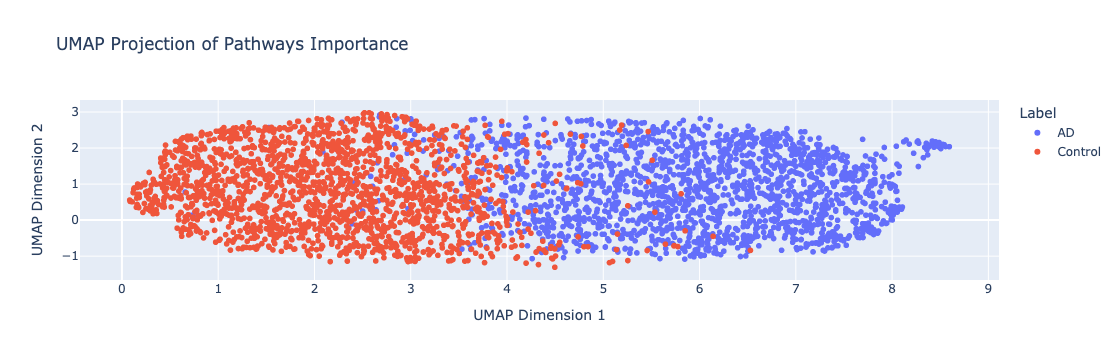

In [65]:
import pandas as pd
import umap
import plotly.express as px
import numpy as np

# Example embeddings (let's assume these are your high-dimensional embeddings)
np.random.seed(42)
embeddings = combined_layer_0.values 
#labels = np.random.choice(['A', 'B', 'C'], size=100)  # Example labels
labels = labels
# Step 1: Reduce dimensionality using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(embeddings)

# Step 2: Create a DataFrame with the reduced dimensions and labels
df_umap = pd.DataFrame({
    'UMAP1': umap_embeddings[:, 0],
    'UMAP2': umap_embeddings[:, 1],
    'Label': labels
})

# Step 3: Plot using Plotly
fig = px.scatter(
    df_umap,
    x='UMAP1',
    y='UMAP2',
    color='Label',
    title='UMAP Projection of Pathways Importance',
    labels={'UMAP1': 'UMAP Dimension 1', 'UMAP2': 'UMAP Dimension 2'}
)

# Show plot
fig.show()


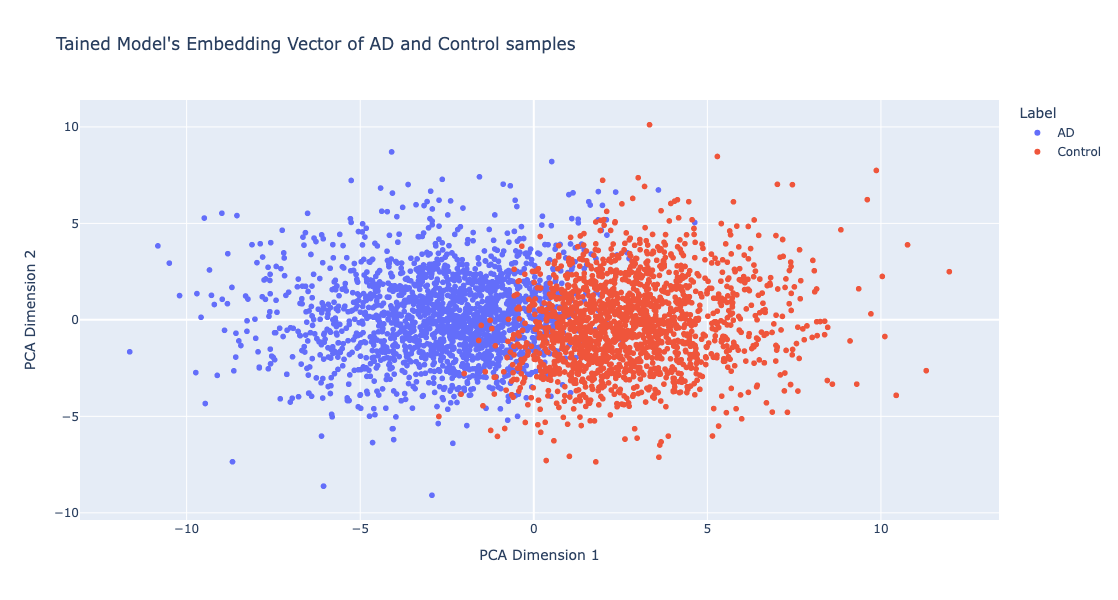

In [73]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA

# Assuming `combined_layer_0` and `labels` are already defined

# Step 1: Reduce dimensionality using PCA
pca = PCA(n_components=2)  # We want to reduce to 2 dimensions
pca_embeddings = pca.fit_transform(combined_layer_0.values)

# Step 2: Create a DataFrame with the reduced dimensions and labels
df_pca = pd.DataFrame({
    'PCA1': pca_embeddings[:, 0],
    'PCA2': pca_embeddings[:, 1],
    'Label': labels
})

# Step 3: Plot using Plotly
fig = px.scatter(
    df_pca,
    x='PCA1',
    y='PCA2',
    color='Label',
    title="Tained Model's Embedding Vector of AD and Control samples",
    labels={'PCA1': 'PCA Dimension 1', 'PCA2': 'PCA Dimension 2'},
    width=800,   # Set plot width
    height=600   # Set plot height
)

# Show plot
fig.show()


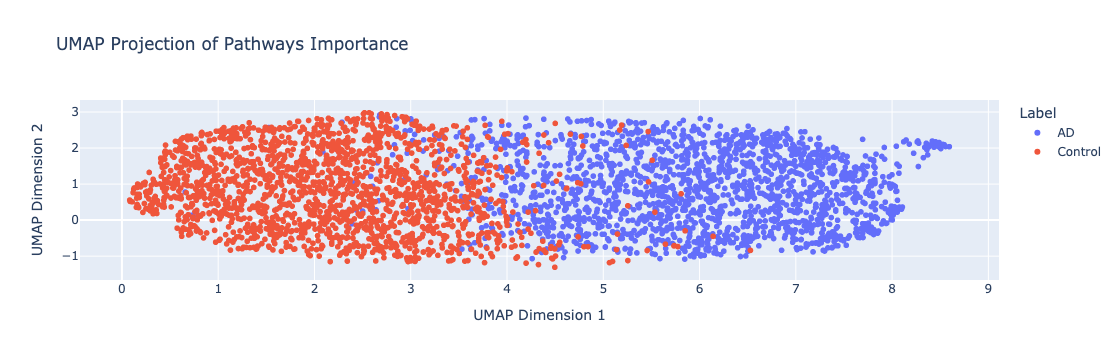

In [69]:
embeddingfig = px.scatter(
    df_umap,
    x='UMAP1',
    y='UMAP2',
    color='Label',
    title='UMAP Projection of Pathways Importance',
    labels={'UMAP1': 'UMAP Dimension 1', 'UMAP2': 'UMAP Dimension 2'},
    width=500,   # Width of the plot in pixels
    height=6000 
)

# Show plot
fig.show()

In [42]:
pd.DataFrame(pathways_list, p_value_list)

""


In [43]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_3_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 554142.80it/s]


In [44]:
layer_1_df

,R-HSA-417957,R-HSA-162592,R-HSA-5654689,R-HSA-75896,R-HSA-5654716,R-HSA-159231,R-HSA-5210891,R-HSA-113507,R-HSA-5339716,R-HSA-9034864,...,R-HSA-5655291_copy1,R-HSA-5654688,R-HSA-6783310_copy1,R-HSA-5675482,R-HSA-9027604,R-HSA-5661231,R-HSA-2979096,R-HSA-901042,R-HSA-9665348,R-HSA-77288
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,0.003275,0.009810,-0.015456,0.000000,0.001502,0.001915,0.009021,-0.010476,-0.006433,-0.000057,...,0.027487,0.000277,0.002091,-0.000094,0.000000,0.000000,0.012869,-0.000795,0.011302,-0.000602
AGCTTCCGTCTCTCTG.9.9,0.000000,0.012895,-0.005234,0.000000,-0.003001,0.000000,0.010151,-0.005489,-0.002985,0.000000,...,0.008764,0.000000,0.000000,0.000000,0.000000,0.000000,0.023016,0.000000,0.000332,0.000000
CGCCAGACAACAAGTA.17.11,0.000000,0.013725,-0.010916,0.000000,-0.001140,0.006392,0.008776,-0.012376,-0.004896,-0.000100,...,0.023170,-0.000132,0.005502,0.003574,-0.000662,0.000000,0.011449,-0.001674,0.009848,-0.000389
GGGATGATCGTAACAC.7.4,0.000000,0.007576,-0.009176,-0.003849,0.012905,0.000000,0.014573,0.000000,-0.005228,-0.000047,...,0.016054,0.000687,0.004162,-0.004238,0.000000,0.000000,0.016451,0.000013,0.015558,0.000000
ACGTTCCGTATTCTCT.5.11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034737,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,0.012875,0.000000,0.000000,0.000000,0.000000,0.000000,0.006510,-0.006484,-0.003527,0.000000,...,0.000000,0.000000,0.009876,0.006180,0.000000,0.000000,0.003763,-0.004656,0.000000,-0.001288
GTCAGCGGTCTGATAC.45.2,0.000000,0.025255,-0.016036,0.000000,-0.005883,0.000000,0.013536,-0.007280,-0.001409,-0.000141,...,0.033405,-0.000373,-0.001616,-0.004335,0.000000,0.000069,0.016819,0.000014,0.011218,0.000000
CATGCTCAGTGTCATC.30.10,0.000000,0.020581,-0.013634,0.000000,-0.011415,0.000000,0.013967,-0.013448,-0.003815,-0.000052,...,0.025742,-0.000368,0.000013,-0.003372,0.000000,0.000000,0.008851,0.000011,0.001313,0.000000


In [45]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_4_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i)) 
layer_2_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_2'])

li = []
for i in layer_dict['layer_3']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 443773.69it/s]


In [46]:
layer_2_df

,R-HSA-5655332,R-HSA-5693537,R-HSA-5205647,R-HSA-881907,R-HSA-2660825,R-HSA-5654696,R-HSA-109704,R-HSA-198753,R-HSA-211976,R-HSA-5654687,...,R-HSA-389356,R-HSA-8979227,R-HSA-446353,R-HSA-196807,R-HSA-1181150,R-HSA-1839124,R-HSA-6804758,R-HSA-3371571,R-HSA-5260271,R-HSA-8963898
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,-0.003298,-0.000165,-0.001825,-0.000286,0.001378,-0.003232,0.001074,-0.000682,0.000001,0.000799,...,0.000024,0.001375,0.000942,-0.000680,-0.000505,-0.000043,0.000042,-0.000133,0.002777,0.004619
AGCTTCCGTCTCTCTG.9.9,-0.001275,-0.000542,0.003747,0.000000,0.002781,-0.001038,0.000221,-0.000620,0.000007,0.000482,...,0.000059,0.000580,0.001331,-0.000299,-0.000403,-0.000027,0.000000,-0.000133,0.004294,0.001991
CGCCAGACAACAAGTA.17.11,-0.002072,-0.000194,-0.000583,0.000020,0.001338,-0.003624,0.000773,-0.000940,0.000005,0.000524,...,-0.000422,0.001126,0.001401,-0.000515,-0.000350,-0.000085,0.000048,-0.000117,0.003689,0.003816
GGGATGATCGTAACAC.7.4,-0.001756,-0.000536,0.001314,-0.000621,0.001628,-0.001184,0.001733,-0.000956,0.000010,-0.000068,...,0.000212,0.001284,0.001769,-0.000462,-0.000622,-0.000023,0.000000,-0.000158,0.002709,0.004330
ACGTTCCGTATTCTCT.5.11,0.000000,0.000000,-0.004301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000240,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,0.000000,-0.000968,-0.004846,0.000000,0.000000,0.000000,0.000000,-0.001352,0.000008,0.000000,...,0.000000,0.001268,0.001014,-0.000750,0.000000,-0.000026,0.000000,0.000000,0.003127,0.004278
GTCAGCGGTCTGATAC.45.2,-0.003111,0.000000,0.003738,0.000186,0.001664,-0.005484,0.000576,-0.001488,0.000012,0.000944,...,-0.000818,0.000000,0.000000,-0.000397,-0.000792,-0.000100,0.000000,-0.000109,0.002332,0.000000
CATGCTCAGTGTCATC.30.10,-0.003066,-0.000559,0.005367,0.000263,0.000776,-0.003960,0.001311,-0.000742,0.000011,0.001265,...,-0.000353,0.001623,0.001542,-0.000403,-0.000563,-0.000065,0.000028,-0.000110,0.000000,0.005398


# layer_2_df

# Plots

In [782]:
!pwd

/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network
